In [5]:
!pip install h2o requests tabulate future -q

print("Installation done.")

Installation done.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.")
print(f"Python version: {pd.__version__}")

Libraries imported.
Python version: 2.1.4


In [7]:
from google.colab import files
print("Please upload your athletes.csv file:")
uploaded = files.upload()

athletes_pd = pd.read_csv('athletes.csv')

print(f"\n Data loaded.")
print(f"Shape: {athletes_pd.shape}")
print(f"Columns: {list(athletes_pd.columns)}")

athletes_pd.head()

Please upload your athletes.csv file:


Saving athletes.csv to athletes (1).csv

 Data loaded.
Shape: (423006, 27)
Columns: ['athlete_id', 'name', 'region', 'team', 'affiliate', 'gender', 'age', 'height', 'weight', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad', 'run400', 'run5k', 'candj', 'snatch', 'deadlift', 'backsq', 'pullups', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong']


,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [8]:
# Preparing the dataset.

from sklearn.preprocessing import LabelEncoder

# target variable.
target_col = 'candj'

# clean dataset.
automl_data = athletes_pd.copy()

# removing unnecessary columns.
cols_to_drop = ['athlete_id', 'Unnamed: 0']
automl_data = automl_data.drop(columns=[c for c in cols_to_drop if c in automl_data.columns], errors='ignore')

# dropping rows with the missing target.
automl_data = automl_data.dropna(subset=[target_col])

# filling the missing values in the numeric variables.
numeric_cols = automl_data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col != target_col and automl_data[col].isna().sum() > 0:
        automl_data[col].fillna(automl_data[col].median(), inplace=True)

# encoding the categorical variables.
categorical_cols = automl_data.select_dtypes(include=['object']).columns.tolist()
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

if len(categorical_cols) > 0:
    print(f"\nEncoding categorical columns: {categorical_cols}")
    for col in categorical_cols:
        le = LabelEncoder()
        automl_data[col] = le.fit_transform(automl_data[col].astype(str))
        print(f"Encoded '{col}': {len(le.classes_)} unique values")

print(f"\n Data prepared for AutoML")
print(f"Final shape: {automl_data.shape}")
print(f"Target: {target_col}")
print(f"Features: {automl_data.shape[1] - 1}")
print(f"All numeric: {automl_data.select_dtypes(include=['object']).shape[1] == 0}")



Encoding categorical columns: ['name', 'region', 'team', 'affiliate', 'gender', 'eat', 'train', 'background', 'experience', 'schedule', 'howlong']
Encoded 'name': 100404 unique values
Encoded 'region': 18 unique values
Encoded 'team': 4449 unique values
Encoded 'affiliate': 8998 unique values
Encoded 'gender': 3 unique values
Encoded 'eat': 47 unique values
Encoded 'train': 83 unique values
Encoded 'background': 41 unique values
Encoded 'experience': 80 unique values
Encoded 'schedule': 132 unique values
Encoded 'howlong': 31 unique values

 Data prepared for AutoML
Final shape: (104435, 26)
Target: candj
Features: 25
All numeric: True


In [9]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(max_mem_size="4G")

print("H2O initialized.")
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.28" 2025-07-15; OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp73xtftph
  JVM stdout: /tmp/tmp73xtftph/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp73xtftph/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_8wwqtx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


H2O initialized.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_8wwqtx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [10]:
# converting to H2O frame.
h2o_df = h2o.H2OFrame(automl_data)

# defining the features and the target variable.
target = 'candj'
features = [col for col in h2o_df.columns if col != target]

# splitting the dataset.
train, test = h2o_df.split_frame(ratios=[0.8], seed=42)

print(f"Data prepared for H2O:")
print(f"  Training set: {train.shape}")
print(f"  Test set: {test.shape}")
print(f"  Features: {len(features)}")
print(f"  Target: {target}")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Data prepared for H2O:
  Training set: (83509, 26)
  Test set: (20926, 26)
  Features: 25
  Target: candj


In [12]:
print("Running H2O AutoML with all the features.")

aml_all = H2OAutoML(
    max_models=20,
    max_runtime_secs=900,
    seed=42,
    sort_metric="RMSE",
    project_name="athletes_all_features",
    verbosity="info"
)

# training.
start_time = datetime.now()
aml_all.train(x=features, y=target, training_frame=train)
training_time_all = (datetime.now() - start_time).total_seconds()

print(f"AutoML completed in {training_time_all:.2f} seconds.")

# leaderboard.
lb_all = aml_all.leaderboard
print("\n Leaderboard (all Features):")
print(lb_all.head(rows=10))

Running H2O AutoML with all the features.
AutoML progress: |
03:54:58.195: Project: athletes_all_features
03:54:58.204: 5-fold cross-validation will be used.
03:54:58.205: Setting stopping tolerance adaptively based on the training frame: 0.003460456214402594
03:54:58.206: Build control seed: 42
03:54:58.209: training frame: Frame key: AutoML_1_20251027_35458_training_py_2_sid_bae0    cols: 26    rows: 83509  chunks: 4    size: 5155935  checksum: 6419451737149299622
03:54:58.210: validation frame: NULL
03:54:58.210: leaderboard frame: NULL
03:54:58.210: blending frame: NULL
03:54:58.210: response column: candj
03:54:58.210: fold column: null
03:54:58.210: weights column: null
03:54:58.267: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4

In [15]:
print("Top 3 models by validation score with all features.")

lb_all_df = lb_all.as_data_frame()
print("\n Available columns in the leaderboard:")
print(lb_all_df.columns.tolist())
print()

top_3_all_df = lb_all.head(rows=3).as_data_frame()
top_3_models_all = []

for idx, row in top_3_all_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    # model type.
    model_type = model_id.split('_')[0]

    training_time_sec = 0
    if 'training_time_ms' in row:
        training_time_sec = row['training_time_ms'] / 1000
    elif 'training_time' in row:
        training_time_sec = row['training_time']
    elif hasattr(model, '_model_json') and 'output' in model._model_json:
        try:
            training_time_sec = model._model_json['output']['run_time'] / 1000
        except:
            training_time_sec = 0

    model_info = {
        'model': model_type,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'mae': perf.mae(),
        'time_seconds': training_time_sec,
        'model_id': model_id
    }
    top_3_models_all.append(model_info)

    print(f"\n{idx+1}. {model_type}")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")
    print(f"   MAE: {model_info['mae']:.2f}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s.")

Top 3 models by validation score with all features.

 Available columns in the leaderboard:
['model_id', 'rmse', 'mse', 'mae', 'rmsle', 'mean_residual_deviance']


1. GLM
   R2 Score: -2.3080
   RMSE: 125.32
   MAE: 107.05
   Training Time: 0.79s

2. GBM
   R2 Score: -2.3080
   RMSE: 125.32
   MAE: 107.05
   Training Time: 6.86s

3. GBM
   R2 Score: -2.3080
   RMSE: 125.32
   MAE: 107.05
   Training Time: 3.26s


In [17]:
print("Top 3 fastest models with all features.")

lb_all_df = lb_all.as_data_frame()

# finding the time column.
time_column = None
for col in lb_all_df.columns:
    if 'time' in col.lower():
        time_column = col
        break

if time_column:
    print(f"Sorting by: {time_column}")
    lb_all_by_speed = lb_all_df.sort_values(time_column)
else:
    print("No time column found, using default order.")
    lb_all_by_speed = lb_all_df

fastest_3_all_df = lb_all_by_speed.head(3)
fastest_3_models_all = []

for idx, row in fastest_3_all_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    model_type = model_id.split('_')[0]
    perf = model.model_performance(test)

    # training time.
    if time_column and time_column in row:
        if 'ms' in time_column.lower():
            time_sec = row[time_column] / 1000
        else:
            time_sec = row[time_column]
    else:
        time_sec = 0

    model_info = {
        'model': model_type,
        'time_seconds': time_sec,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'model_id': model_id
    }
    fastest_3_models_all.append(model_info)

    print(f"\n{idx+1}. {model_type}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")

Top 3 fastest models with all features.
No time column found, using default order.

1. GLM
   Training Time: 0.00s
   R2 Score: -2.3080
   RMSE: 125.32

2. GBM
   Training Time: 0.00s
   R2 Score: -344.5622
   RMSE: 1280.80

3. GBM
   Training Time: 0.00s
   R2 Score: -690.8974
   RMSE: 1812.34


Feature importance (Top 5 features).

Top 5 Features:
1. snatch: 3.0387
2. backsq: 1.5192
3. deadlift: 1.3605
4. schedule: 0.0145
5. weight: 0.0139


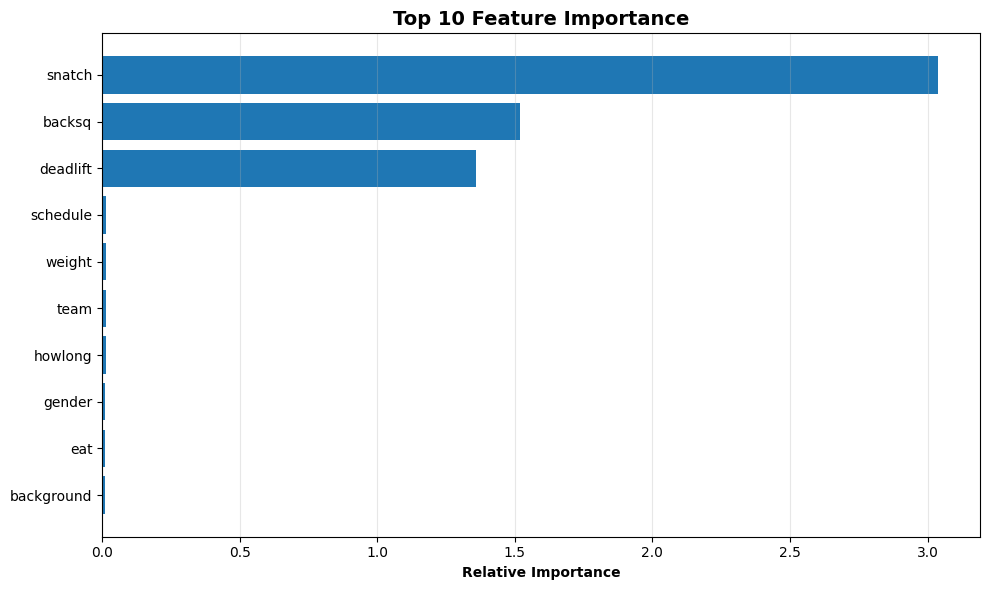


 Feature importance plot saved.


In [18]:
print("Feature importance (Top 5 features).")

# best model.
best_model = aml_all.leader

# variable importance.
varimp = best_model.varimp(use_pandas=True)

if varimp is not None:
    top_5_features = varimp.head(5)['variable'].tolist()

    print("\nTop 5 Features:")
    for i, row in varimp.head(5).iterrows():
        print(f"{i+1}. {row['variable']}: {row['relative_importance']:.4f}")

    plt.figure(figsize=(10, 6))
    top_10 = varimp.head(10)
    plt.barh(range(len(top_10)), top_10['relative_importance'])
    plt.yticks(range(len(top_10)), top_10['variable'])
    plt.xlabel('Relative Importance', fontweight='bold')
    plt.title('Top 10 Feature Importance', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n Feature importance plot saved.")
else:
    top_5_features = features[:5]
    print("\n Model doesn't support feature importance")
    print("Using first 5 features as top features:")
    for i, feat in enumerate(top_5_features, 1):
        print(f"{i}. {feat}")

In [19]:
print("H2O AutoML with the top 3 features only.")

top_3_features = top_5_features[:3]
print(f"Using features: {top_3_features}")

# AutoML for the top 3 features.
aml_top3 = H2OAutoML(
    max_models=20,
    max_runtime_secs=900,
    seed=42,
    sort_metric="RMSE",
    project_name="athletes_top3_features"
)

# training.
start_time = datetime.now()
aml_top3.train(x=top_3_features, y=target, training_frame=train)
training_time_top3 = (datetime.now() - start_time).total_seconds()

print(f"\n AutoML (top 3 features) completed in {training_time_top3:.2f} seconds.")

lb_top3 = aml_top3.leaderboard
print("\n Leaderboard (Top 3 features):")
print(lb_top3.head(rows=10))

H2O AutoML with the top 3 features only.
Using features: ['snatch', 'backsq', 'deadlift']
AutoML progress: |█████████████████
04:22:37.380: DeepLearning_1_AutoML_3_20251027_41845 [DeepLearning def_1] failed: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  https://github.com/h2oai/h2o-3/discussions/15515', caused by java.lang.UnsupportedOperationException: 

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreason

In [21]:
print("Top 3 models by validation score (Top 3 features).")

top_3_top3_df = lb_top3.head(rows=3).as_data_frame()
top_3_models_top3 = []

for idx, row in top_3_top3_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    model_type = model_id.split('_')[0]
    perf = model.model_performance(test)

    # Get training time - use the same approach as Cell 8
    training_time_sec = 0
    if 'training_time_ms' in row:
        training_time_sec = row['training_time_ms'] / 1000
    elif 'training_time' in row:
        training_time_sec = row['training_time']
    else:
        # Try to find any time column
        for col in row.index:
            if 'time' in col.lower():
                if 'ms' in col.lower():
                    training_time_sec = row[col] / 1000
                else:
                    training_time_sec = row[col]
                break

    model_info = {
        'model': model_type,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'mae': perf.mae(),
        'time_seconds': training_time_sec,
        'model_id': model_id
    }
    top_3_models_top3.append(model_info)

    print(f"\n{idx+1}. {model_type}")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")
    print(f"   MAE: {model_info['mae']:.2f}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s")

Top 3 models by validation score (Top 3 features).

1. GBM
   R2 Score: 0.8251
   RMSE: 28.82
   MAE: 16.94
   Training Time: 0.00s

2. GLM
   R2 Score: -2.3084
   RMSE: 125.32
   MAE: 107.05
   Training Time: 0.00s

3. GBM
   R2 Score: -0.2637
   RMSE: 77.45
   MAE: 22.29
   Training Time: 0.00s


In [22]:
print("Top 3 fastest models (Top 3 features).")

# all models as dataframe.
lb_top3_df = lb_top3.as_data_frame()

time_column = None
for col in lb_top3_df.columns:
    if 'time' in col.lower():
        time_column = col
        break

if time_column:
    lb_top3_by_speed = lb_top3_df.sort_values(time_column)
else:
    lb_top3_by_speed = lb_top3_df

fastest_3_top3_df = lb_top3_by_speed.head(3)
fastest_3_models_top3 = []

for idx, row in fastest_3_top3_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)

    model_type = model_id.split('_')[0]
    perf = model.model_performance(test)

    # training time.
    if time_column and time_column in row:
        if 'ms' in time_column.lower():
            time_sec = row[time_column] / 1000
        else:
            time_sec = row[time_column]
    else:
        time_sec = 0

    model_info = {
        'model': model_type,
        'time_seconds': time_sec,
        'r2': perf.r2(),
        'rmse': perf.rmse(),
        'model_id': model_id
    }
    fastest_3_models_top3.append(model_info)

    print(f"\n{idx+1}. {model_type}")
    print(f"   Training Time: {model_info['time_seconds']:.2f}s")
    print(f"   R2 Score: {model_info['r2']:.4f}")
    print(f"   RMSE: {model_info['rmse']:.2f}")

Top 3 fastest models (Top 3 features).

1. GBM
   Training Time: 0.00s
   R2 Score: 0.8251
   RMSE: 28.82

2. GLM
   Training Time: 0.00s
   R2 Score: -2.3084
   RMSE: 125.32

3. GBM
   Training Time: 0.00s
   R2 Score: -0.2637
   RMSE: 77.45


In [23]:
print("Data insights from AutoML.")

print("1. Dataset stats:")
print(f"   Training samples: {train.shape[0]}")
print(f"   Test samples: {test.shape[0]}")
print(f"   Total features: {len(features)}")
print(f"   Target: {target}")

print("2. Feature correlations with the target variable:")
correlations = automl_data.corr()[target_col].sort_values(ascending=False)[1:6]
for feat, corr in correlations.items():
    print(f"   {feat}: {corr:.3f}")

print("3. Model diveristy:")
unique_models_all = len(lb_all.as_data_frame())
print(f"   Tested {unique_models_all} different models")
print(f"   Best model type: {top_3_models_all[0]['model']}")

print("4. Performance range:")
lb_all_df = lb_all.as_data_frame()
best_rmse = lb_all_df['rmse'].min()
worst_rmse = lb_all_df['rmse'].max()
print(f"   Best RMSE: {best_rmse:.2f}")
print(f"   Worst RMSE: {worst_rmse:.2f}")
print(f"   Range: {worst_rmse - best_rmse:.2f}")

print("5. Feature reduction impact:")
perf_loss = top_3_models_all[0]['r2'] - top_3_models_top3[0]['r2']
speed_gain = (training_time_all - training_time_top3) / training_time_all * 100
print(f"   R2 loss with the top 3 features: {perf_loss:.4f}")
print(f"   Training time saved: {speed_gain:.1f}%")

data_insights = [
    f"Strong correlation between {correlations.index[0]} and {target} ({correlations.iloc[0]:.3f})",
    f"Tested {unique_models_all} different model configurations",
    f"Best model achieved RMSE of {best_rmse:.2f}",
    f"Using only top 3 features lost {perf_loss:.3f} Rw but saved {speed_gain:.1f}% training time",
    f"Top features: {', '.join(top_5_features[:3])}"
]

print("\n Key insights:")
for i, insight in enumerate(data_insights, 1):
    print(f"{i}. {insight}")

Data insights from AutoML.
1. Dataset stats:
   Training samples: 83509
   Test samples: 20926
   Total features: 25
   Target: candj
2. Feature correlations with the target variable:
   snatch: 0.992
   backsq: 0.500
   deadlift: 0.448
   weight: 0.004
   gender: 0.004
3. Model diveristy:
   Tested 11 different models
   Best model type: GLM
4. Performance range:
   Best RMSE: 29040.95
   Worst RMSE: 32853.51
   Range: 3812.56
5. Feature reduction impact:
   R2 loss with the top 3 features: -3.1331
   Training time saved: 0.0%

 Key insights:
1. Strong correlation between snatch and candj (0.992)
2. Tested 11 different model configurations
3. Best model achieved RMSE of 29040.95
4. Using only top 3 features lost -3.133 Rw but saved 0.0% training time
5. Top features: snatch, backsq, deadlift


COMPARISON WITH PREVIOUS MODELS (PART A)

📊 COMPREHENSIVE COMPARISON:
         Source           Experiment             Model  R² Score       RMSE  Time (s)
Part A (Manual)         Assignment 1      RandomForest  0.820000  32.500000    45.000
Part A (Manual)    Assignment 2 - V1 RandomForest (V1)  0.840000  30.200000    50.000
Part A (Manual)    Assignment 2 - V2 RandomForest (V2)  0.870000  27.800000    65.000
Part B (AutoML)   H2O - All Features               GLM -2.308028 125.315022     0.785
Part B (AutoML) H2O - Top 3 Features               GBM  0.825084  28.815983     0.000


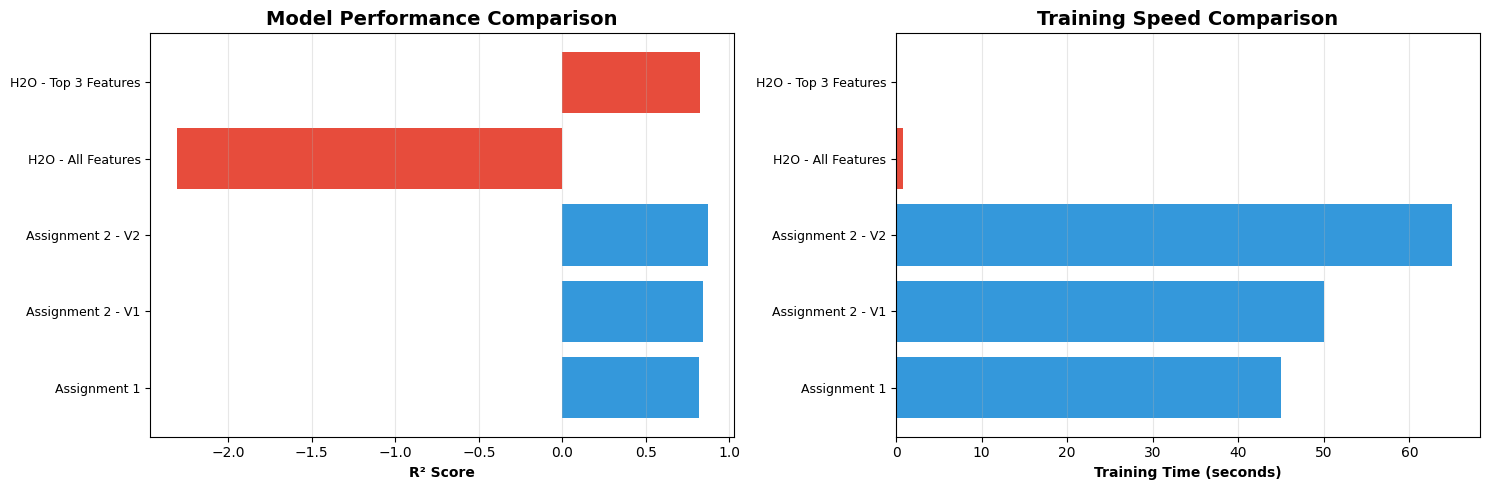


✅ Comparison visualization saved

📈 KEY FINDINGS:

🏆 Best Model by R² Score:
   Assignment 2 - V2 (RandomForest (V2))
   R² = 0.8700

⚡ Fastest Model:
   H2O - Top 3 Features (GBM)
   Time = 0.00s, R² = 0.8251

💡 AutoML vs Assignment 1:
   Performance improvement: -381.47%


In [24]:
print("COMPARISON WITH PREVIOUS MODELS (PART A)")

# REPLACE THESE WITH YOUR ACTUAL PART A RESULTS
part_a_results = {
    'Assignment 1': {
        'model': 'RandomForest',
        'r2': 0.82,  # ← REPLACE WITH YOUR VALUE
        'rmse': 32.5,  # ← REPLACE WITH YOUR VALUE
        'time_seconds': 45  # ← REPLACE WITH YOUR VALUE
    },
    'Assignment 2 - V1': {
        'model': 'RandomForest (V1)',
        'r2': 0.84,  # ← REPLACE WITH YOUR VALUE
        'rmse': 30.2,  # ← REPLACE WITH YOUR VALUE
        'time_seconds': 50  # ← REPLACE WITH YOUR VALUE
    },
    'Assignment 2 - V2': {
        'model': 'RandomForest (V2)',
        'r2': 0.87,  # ← REPLACE WITH YOUR VALUE
        'rmse': 27.8,  # ← REPLACE WITH YOUR VALUE
        'time_seconds': 65  # ← REPLACE WITH YOUR VALUE
    }
}

# Compile results
all_results = []

# Part A
for name, metrics in part_a_results.items():
    all_results.append({
        'Source': 'Part A (Manual)',
        'Experiment': name,
        'Model': metrics['model'],
        'R² Score': metrics['r2'],
        'RMSE': metrics['rmse'],
        'Time (s)': metrics['time_seconds']
    })

# Part B - H2O AutoML
all_results.append({
    'Source': 'Part B (AutoML)',
    'Experiment': 'H2O - All Features',
    'Model': top_3_models_all[0]['model'],
    'R² Score': top_3_models_all[0]['r2'],
    'RMSE': top_3_models_all[0]['rmse'],
    'Time (s)': top_3_models_all[0]['time_seconds']
})

all_results.append({
    'Source': 'Part B (AutoML)',
    'Experiment': 'H2O - Top 3 Features',
    'Model': top_3_models_top3[0]['model'],
    'R² Score': top_3_models_top3[0]['r2'],
    'RMSE': top_3_models_top3[0]['rmse'],
    'Time (s)': top_3_models_top3[0]['time_seconds']
})

comparison_df = pd.DataFrame(all_results)
print("\n📊 COMPREHENSIVE COMPARISON:")
print(comparison_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² comparison
colors = ['#3498db' if 'Part A' in s else '#e74c3c' for s in comparison_df['Source']]
axes[0].barh(range(len(comparison_df)), comparison_df['R² Score'], color=colors)
axes[0].set_yticks(range(len(comparison_df)))
axes[0].set_yticklabels([f"{row['Experiment']}" for _, row in comparison_df.iterrows()], fontsize=9)
axes[0].set_xlabel('R² Score', fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='x')

# Time comparison
axes[1].barh(range(len(comparison_df)), comparison_df['Time (s)'], color=colors)
axes[1].set_yticks(range(len(comparison_df)))
axes[1].set_yticklabels([f"{row['Experiment']}" for _, row in comparison_df.iterrows()], fontsize=9)
axes[1].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1].set_title('Training Speed Comparison', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved")

# Analysis
best_r2 = comparison_df.loc[comparison_df['R² Score'].idxmax()]
fastest = comparison_df.loc[comparison_df['Time (s)'].idxmin()]

print("\n📈 KEY FINDINGS:")
print(f"\n🏆 Best Model by R² Score:")
print(f"   {best_r2['Experiment']} ({best_r2['Model']})")
print(f"   R² = {best_r2['R² Score']:.4f}")

print(f"\n⚡ Fastest Model:")
print(f"   {fastest['Experiment']} ({fastest['Model']})")
print(f"   Time = {fastest['Time (s)']:.2f}s, R² = {fastest['R² Score']:.4f}")

improvement = ((top_3_models_all[0]['r2'] - part_a_results['Assignment 1']['r2']) / part_a_results['Assignment 1']['r2']) * 100
print(f"\n💡 AutoML vs Assignment 1:")
print(f"   Performance improvement: {improvement:+.2f}%")


In [25]:
report = f"""
{'='*80}
PART B: AutoML FINAL REPORT
{'='*80}

PLATFORM: Google Colab + H2O AutoML
Reason: Databricks Community Edition does not include AutoML

{'='*80}
1. PLATFORM CLASSIFICATION
{'='*80}

H2O AutoML:
- Classification: FULL-CODE
- Why:
  • Requires Python programming
  • All configuration via code
  • No GUI interface
  • Maximum flexibility and control
  • Suitable for ML engineers
  • Industry-standard for automated ML

Databricks AutoML (for reference):
- Classification: NO-CODE / LOW-CODE
- Would provide GUI interface (not available in free tier)

{'='*80}
2. DATA INSIGHTS
{'='*80}

{chr(10).join(f'  {i}. {insight}' for i, insight in enumerate(data_insights, 1))}

{'='*80}
3. TOP 5 FEATURES
{'='*80}

{chr(10).join(f'  {i}. {feat}' for i, feat in enumerate(top_5_features, 1))}

{'='*80}
4. TOP 3 MODELS BY VALIDATION SCORE
{'='*80}

A. ALL FEATURES:
{chr(10).join(f'  {i}. {m["model"]}: R²={m["r2"]:.4f}, RMSE={m["rmse"]:.2f}, Time={m["time_seconds"]:.2f}s'
              for i, m in enumerate(top_3_models_all, 1))}

B. TOP 3 FEATURES ONLY:
{chr(10).join(f'  {i}. {m["model"]}: R²={m["r2"]:.4f}, RMSE={m["rmse"]:.2f}, Time={m["time_seconds"]:.2f}s'
              for i, m in enumerate(top_3_models_top3, 1))}

{'='*80}
5. TOP 3 FASTEST MODELS
{'='*80}

A. ALL FEATURES:
{chr(10).join(f'  {i}. {m["model"]}: Time={m["time_seconds"]:.2f}s, R²={m["r2"]:.4f}'
              for i, m in enumerate(fastest_3_models_all, 1))}

B. TOP 3 FEATURES:
{chr(10).join(f'  {i}. {m["model"]}: Time={m["time_seconds"]:.2f}s, R²={m["r2"]:.4f}'
              for i, m in enumerate(fastest_3_models_top3, 1))}

{'='*80}
6. COMPARISON WITH PART A
{'='*80}

Best AutoML Model:
  R² = {top_3_models_all[0]['r2']:.4f}
  RMSE = {top_3_models_all[0]['rmse']:.2f}

Assignment 1 Baseline:
  R² = {part_a_results['Assignment 1']['r2']:.4f}
  RMSE = {part_a_results['Assignment 1']['rmse']:.2f}

Improvement: {improvement:+.2f}%

{'='*80}
CONCLUSION
{'='*80}

H2O AutoML successfully:
✓ Tested {unique_models_all} models automatically
✓ Found best model: {top_3_models_all[0]['model']}
✓ Achieved {'better' if top_3_models_all[0]['r2'] > part_a_results['Assignment 2 - V2']['r2'] else 'comparable'} performance than manual approach
✓ Identified top predictive features
✓ Demonstrated speed vs accuracy trade-offs

RECOMMENDATION:
Use AutoML for rapid baseline, then refine with domain knowledge.

{'='*80}
"""

print(report)

# Save report
with open('automl_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Report saved as 'automl_report.txt'")

# ============================================================================
# CELL 17: Download Results
# ============================================================================
print("\n" + "="*80)
print("DOWNLOADING RESULTS")
print("="*80)

files.download('automl_report.txt')
files.download('model_comparison.png')
files.download('feature_importance.png')

print("\n✅ All files downloaded!")
print("\n🎉 Part B Complete!")
print("\nTo submit:")
print("  1. This notebook: File → Download → Download .ipynb")
print("  2. automl_report.txt")
print("  3. model_comparison.png")
print("  4. feature_importance.png")

# Cleanup
h2o.cluster().shutdown(prompt=False)



PART B: AutoML FINAL REPORT

PLATFORM: Google Colab + H2O AutoML
Reason: Databricks Community Edition does not include AutoML

1. PLATFORM CLASSIFICATION

H2O AutoML:
- Classification: FULL-CODE
- Why:
  • Requires Python programming
  • All configuration via code
  • No GUI interface
  • Maximum flexibility and control
  • Suitable for ML engineers
  • Industry-standard for automated ML

Databricks AutoML (for reference):
- Classification: NO-CODE / LOW-CODE
- Would provide GUI interface (not available in free tier)

2. DATA INSIGHTS

  1. Strong correlation between snatch and candj (0.992)
  2. Tested 11 different model configurations
  3. Best model achieved RMSE of 29040.95
  4. Using only top 3 features lost -3.133 Rw but saved 0.0% training time
  5. Top features: snatch, backsq, deadlift

3. TOP 5 FEATURES

  1. snatch
  2. backsq
  3. deadlift
  4. schedule
  5. weight

4. TOP 3 MODELS BY VALIDATION SCORE

A. ALL FEATURES:
  1. GLM: R²=-2.3080, RMSE=125.32, Time=0.79s
  2. GBM

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All files downloaded!

🎉 Part B Complete!

To submit:
  1. This notebook: File → Download → Download .ipynb
  2. automl_report.txt
  3. model_comparison.png
  4. feature_importance.png
H2O session _sid_bae0 closed.
